Install Contrastive


In [1]:
!pip install contrastive

  Preparing metadata (setup.py) ... done
  Created wheel for contrastive: filename=contrastive-1.2.0-py3-none-any.whl size=6898 sha256=9d397164ac5dbca84ca765dbde4f618eb32785bd52a55e4942f20104cf9f745a
  Stored in directory: /root/.cache/pip/wheels/b4/2a/ad/111239c0d6a0b248f0ee4b903b6b44cc9cdfc1cfcff81ebba2
Successfully built contrastive


Download Iris dataset

In [1]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

import numpy as np

data = load_iris()
print(data.keys())


X_data = np.asarray(data["data"])
y_data = np.asarray(data["target"])

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


Create a noise generator feature

In [2]:
X_data_noise = np.zeros((4, 150))

for feature in range(len(X_data[0])):
    original_mean = np.mean(X_data[:, feature])
    original_std = np.std(X_data[:, feature])

    X_data_noise[feature] = np.random.normal(original_mean, original_std, 150)

Visualize real data and data with noise generation

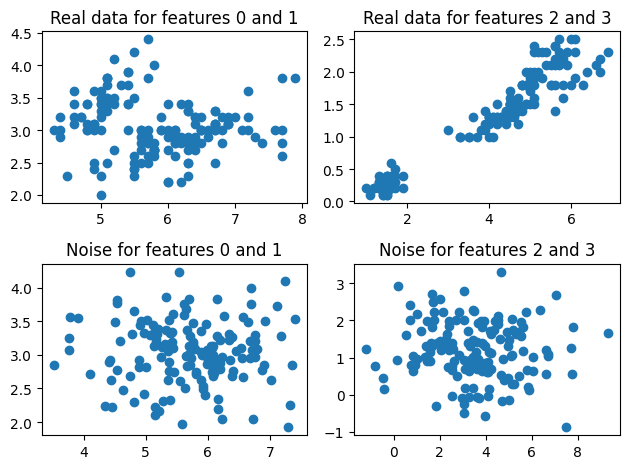

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)
axs[0, 0].set_title("Real data for features 0 and 1")
axs[0, 0].scatter(X_data[:, 0], X_data[:, 1])
axs[0, 1].set_title("Real data for features 2 and 3")
axs[0, 1].scatter(X_data[:, 2], X_data[:, 3])
axs[1, 0].set_title("Noise for features 0 and 1")
axs[1, 0].scatter(X_data_noise[0], X_data_noise[1])
axs[1, 1].set_title("Noise for features 2 and 3")
axs[1, 1].scatter(X_data_noise[2], X_data_noise[3])
fig.tight_layout()

Implement PCA on 2 dimensions

In [4]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
X_data_original_compress = pca_model.fit_transform(X_data)

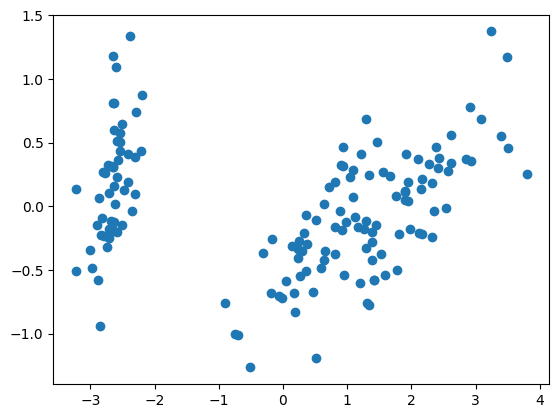

In [5]:
plt.scatter(X_data_original_compress[:, 0], X_data_original_compress[:, 1])

Run PCA

In [6]:
from contrastive import CPCA

print(X_data.shape)
print(X_data_noise.T.shape)
cpca_model = CPCA(n_components=2)
transformed_data = cpca_model.fit_transform(X_data, X_data_noise.T)
transformed_data = np.asarray(transformed_data)
print(transformed_data.shape)

(150, 4)
(150, 4)
(4, 150, 2)


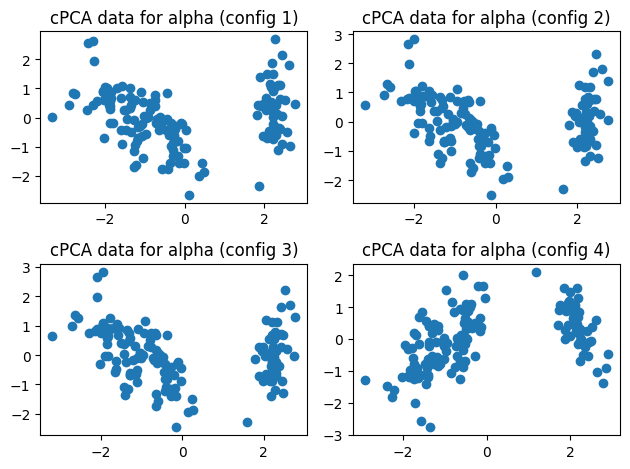

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)
P = transformed_data
axs[0, 0].set_title("cPCA data for alpha (config 1)")
axs[0, 0].scatter(P[0, :, 0], P[0, :, 1])
axs[0, 1].set_title("cPCA data for alpha (config 2)")
axs[0, 1].scatter(P[1, :, 0], P[1, :, 1])
axs[1, 0].set_title("cPCA data for alpha (config 3)")
axs[1, 0].scatter(P[2, :, 0], P[2, :, 1])
axs[1, 1].set_title("cPCA data for alpha (config 4)")
axs[1, 1].scatter(P[3, :, 0], P[3, :, 1])
fig.tight_layout()

Running k-NN on PCA-compressed data

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

mean_acc = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        X_data_original_compress, y_data
    )
    knn_clf = KNeighborsClassifier(n_neighbors=5)
    knn_clf.fit(X_train, y_train)
    mean_acc.append(knn_clf.score(X_test, y_test))
print(f"{round(np.mean(mean_acc), 5)} +/- {round(np.std(mean_acc), 5)}")

0.97895 +/- 0.01969


Running k-NN on original Iris data

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

mean_acc = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data)
    knn_clf = KNeighborsClassifier(n_neighbors=5)
    knn_clf.fit(X_train, y_train)
    mean_acc.append(knn_clf.score(X_test, y_test))
print(f"{round(np.mean(mean_acc), 5)} +/- {round(np.std(mean_acc), 5)}")

0.95526 +/- 0.02895


Running on cPCA-compressed data, with different values for alpha (cPCA parameter)

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

for i in range(len(transformed_data)):
    mean_acc = []
    for j in range(10):
        X_train, X_test, y_train, y_test = train_test_split(transformed_data[i], y_data)
        knn_clf = KNeighborsClassifier(n_neighbors=5)
        knn_clf.fit(X_train, y_train)
        mean_acc.append(knn_clf.score(X_test, y_test))
    print(f"{round(np.mean(mean_acc), 5)} +/- {round(np.std(mean_acc), 5)}")

0.91842 +/- 0.03804
0.92105 +/- 0.04077
0.92632 +/- 0.02294
0.94211 +/- 0.02578


### Running with 5-Fold Validation

In [12]:
print(X_data.shape)
print(y_data.shape)
list_of_unique_labels = np.unique(y_data)
print(list_of_unique_labels)

(150, 4)
(150,)
[0 1 2]


In [13]:
from sklearn.decomposition import PCA
from contrastive import CPCA
import sklearn as sk
from sklearn.neighbors import KNeighborsClassifier

In [14]:
from sklearn.model_selection import cross_val_score

results_list = []

for i in range(len(list_of_unique_labels)):
    for j in range(len(list_of_unique_labels)):
        if i > j:
            tmp_data_dict = dict()
            tmp_data_dict["name"] = f"Class {i} and Class {j}"
            class_1_indices = np.where(y_data == i)[0]
            # print(class_1_indices)
            class_2_indices = np.where(y_data == j)[0]
            class_1_data = np.take(X_data, class_1_indices, axis=0)
            # print(class_1_data)
            class_2_data = np.take(X_data, class_2_indices, axis=0)
            # print(class_1_data.shape)
            # print(class_2_data.shape)
            background_indices = []
            # y_data_indices = np.zeros(class_1_data.shape[0]+class_2_data.shape[0])
            for k in range(X_data.shape[0]):
                if k not in class_1_indices and i not in class_2_indices:
                    background_indices.append(k)
            background_data = np.take(X_data, background_indices, axis=0)

            X_data_p = np.concatenate((class_1_data, class_2_data), axis=0)
            X_data_noise = background_data
            y_data_p = np.zeros(class_1_data.shape[0] + class_2_data.shape[0])
            class_1_indices = list(range(class_1_data.shape[0]))
            y_data_p[class_1_indices] = 1
            X_data_p, y_data_p = sk.utils.shuffle(X_data_p, y_data_p)

            print(X_data_p.shape)
            print(X_data_noise.shape)

            # PCA processing
            pca_model = PCA(n_components=2)
            X_data_original_compress = pca_model.fit_transform(X_data_p)

            # cPCA preprocessing
            cpca_model = CPCA(n_components=2)
            transformed_data = cpca_model.fit_transform(X_data_p, X_data_noise)
            transformed_data = np.asarray(transformed_data)
            # print(transformed_data.shape)

            # PCA data
            clf = KNeighborsClassifier(n_neighbors=5)
            scores = cross_val_score(clf, X_data_original_compress, y_data_p, cv=5)
            print("PCA")
            print(f"Mean: {round(scores.mean(), 3)}")
            print(f"Std: {round(scores.std(), 3)}")
            print()
            tmp_data_dict["PCA"] = (
                f"{round(scores.mean(), 3)} +/- {round(scores.std(), 3)}"
            )

            # cPCA data
            clf = KNeighborsClassifier(n_neighbors=5)
            scores = cross_val_score(clf, transformed_data[0], y_data_p, cv=5)
            # pprint(scores)
            print("cPCA (custom alpha 1)")
            print(f"Mean: {round(scores.mean(), 3)}")
            print(f"Std: {round(scores.std(), 3)}")
            print()
            tmp_data_dict["cPCA-1"] = (
                f"{round(scores.mean(), 3)} +/- {round(scores.std(), 3)}"
            )

            # cPCA data
            clf = KNeighborsClassifier(n_neighbors=5)
            scores = cross_val_score(clf, transformed_data[1], y_data_p, cv=5)
            # pprint(scores)
            print("cPCA (custom alpha 2)")
            print(f"Mean: {round(scores.mean(), 3)}")
            print(f"Std: {round(scores.std(), 3)}")
            print()
            tmp_data_dict["cPCA-2"] = (
                f"{round(scores.mean(), 3)} +/- {round(scores.std(), 3)}"
            )

            # cPCA data
            clf = KNeighborsClassifier(n_neighbors=5)
            scores = cross_val_score(clf, transformed_data[2], y_data_p, cv=5)
            # pprint(scores)
            print("cPCA (custom alpha 3)")
            print(f"Mean: {round(scores.mean(), 3)}")
            print(f"Std: {round(scores.std(), 3)}")
            print()
            tmp_data_dict["cPCA-3"] = (
                f"{round(scores.mean(), 3)} +/- {round(scores.std(), 3)}"
            )

            # cPCA data
            clf = KNeighborsClassifier(n_neighbors=5)
            scores = cross_val_score(clf, transformed_data[3], y_data_p, cv=5)
            # pprint(scores)
            print("cPCA (custom alpha 4)")
            print(f"Mean: {round(scores.mean(), 3)}")
            print(f"Std: {round(scores.std(), 3)}")
            print()
            tmp_data_dict["cPCA-4"] = (
                f"{round(scores.mean(), 3)} +/- {round(scores.std(), 3)}"
            )

            # on original data
            clf = KNeighborsClassifier(n_neighbors=5)
            scores = cross_val_score(clf, X_data_p, y_data_p, cv=5)
            # pprint(scores)
            print("Original data")
            print(f"Mean: {round(scores.mean(), 3)}")
            print(f"Std: {round(scores.std(), 3)}")
            print()
            print("---")
            tmp_data_dict["original"] = (
                f"{round(scores.mean(), 3)} +/- {round(scores.std(), 3)}"
            )
            results_list.append(tmp_data_dict)

(100, 4)
(0, 4)
PCA
Mean: 1.0
Std: 0.0

cPCA (custom alpha 1)
Mean: 1.0
Std: 0.0



C:\Users\laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


cPCA (custom alpha 2)
Mean: 1.0
Std: 0.0

cPCA (custom alpha 3)
Mean: 1.0
Std: 0.0

cPCA (custom alpha 4)
Mean: 1.0
Std: 0.0

Original data
Mean: 1.0
Std: 0.0

---
(100, 4)
(0, 4)
PCA
Mean: 1.0
Std: 0.0

cPCA (custom alpha 1)
Mean: 1.0
Std: 0.0



C:\Users\laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


cPCA (custom alpha 2)
Mean: 1.0
Std: 0.0

cPCA (custom alpha 3)
Mean: 1.0
Std: 0.0

cPCA (custom alpha 4)
Mean: 1.0
Std: 0.0

Original data
Mean: 1.0
Std: 0.0

---
(100, 4)
(100, 4)
PCA
Mean: 0.91
Std: 0.086

cPCA (custom alpha 1)
Mean: 0.85
Std: 0.077

cPCA (custom alpha 2)
Mean: 0.88
Std: 0.06

cPCA (custom alpha 3)
Mean: 0.85
Std: 0.063

cPCA (custom alpha 4)
Mean: 0.82
Std: 0.068

Original data
Mean: 0.95
Std: 0.032

---


In [16]:
import pandas as pd


def get_acc(x):
    return float(x.split("+/-")[0].strip())


def color_format(s):
    original_acc = get_acc(s["original"])
    print(original_acc)
    # is_max = s == s.max()
    color_list = []
    for i in s:
        print(f"hi: {i}")
        if get_acc(i) <= original_acc:
            color_list.append("background-color: white")
        else:
            color_list.append("background-color: rgb(100,255,100)")
    return color_list


results_df.style.apply(color_format, axis=1)

results_df = pd.DataFrame(results_list)
results_df.set_index("name", inplace=True)
results_df

# take original as a baseline, green: positive, red: negative; darker-green, darker-red for more extreme values (for color scaling)
# for breast cancer dataset: take the average of all (average class from all the images, what an average looking thing looks like - the average picture, use that as the mean background)

,PCA,cPCA-1,cPCA-2,cPCA-3,cPCA-4,original
name,,,,,,
Class 1 and Class 0,1.0 +/- 0.0,1.0 +/- 0.0,1.0 +/- 0.0,1.0 +/- 0.0,1.0 +/- 0.0,1.0 +/- 0.0
Class 2 and Class 0,1.0 +/- 0.0,1.0 +/- 0.0,1.0 +/- 0.0,1.0 +/- 0.0,1.0 +/- 0.0,1.0 +/- 0.0
Class 2 and Class 1,0.91 +/- 0.086,0.85 +/- 0.077,0.88 +/- 0.06,0.85 +/- 0.063,0.82 +/- 0.068,0.95 +/- 0.032
